In [2]:
import pandas as pd #veriyi tablo (DataFrame) formatında tutmamızı sağlar.
import numpy as np #Bilimsel hesaplama kütüphanesidir. Pandas'ın arkasında matematiksel işlemler bu kütüphane ile döner.

#Pandas'ın çıktıları düzgün göstermesi için yapılan ayarlar
pd.set_option ('display.max_columns', None) #tüm sütunlar gösterilsin, gizlenmesin diye ekledik.
pd.set_option('display.width', 500)   #konsol genişliğini tabloları tek satırda düzgün gözüksün diye koyduk.

df= pd.read_excel(r"online_retail_II.xlsx",sheet_name="Year 2010-2011")

print("---ilk 5 satır---") #verinin ilk 5 satırına bakıyoruz ki verinin neye benzediğini görelim
print(df.head())

print("\n---veri seti bilgisi---") #veri seti hakkında genel bilgi: toplam kaç satır var? veri tiplerimiz neler? boş değer var mı?
print(df.info())

print("\n---istatiksel özet---") #negatif değerler veya aykırı sayılar var mı?
print(df.describe().T) #buradaki 'T' (Transpose) tablonun satır ve sütunlarının yerini değiştirir, tabloyu daha rahat okumamızı sağlar.

---ilk 5 satır---
  Invoice StockCode                          Description  Quantity         InvoiceDate  Price  Customer ID         Country
0  536365    85123A   WHITE HANGING HEART T-LIGHT HOLDER         6 2010-12-01 08:26:00   2.55      17850.0  United Kingdom
1  536365     71053                  WHITE METAL LANTERN         6 2010-12-01 08:26:00   3.39      17850.0  United Kingdom
2  536365    84406B       CREAM CUPID HEARTS COAT HANGER         8 2010-12-01 08:26:00   2.75      17850.0  United Kingdom
3  536365    84029G  KNITTED UNION FLAG HOT WATER BOTTLE         6 2010-12-01 08:26:00   3.39      17850.0  United Kingdom
4  536365    84029E       RED WOOLLY HOTTIE WHITE HEART.         6 2010-12-01 08:26:00   3.39      17850.0  United Kingdom

---veri seti bilgisi---
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 541910 entries, 0 to 541909
Data columns (total 8 columns):
 #   Column       Non-Null Count   Dtype         
---  ------       --------------   -----         
 0   Invo

In [3]:
#veri temizliği ve hazırlık

df_clean = df.copy() #orijinal veriyi bozmamak için bir kopyasını alıyoruz

#eksik verileri siliyoruz (Customer ID'si olmayanlar atılıyor)
df_clean.dropna(subset= ["Customer ID"], inplace=True)  #"dropna" fonskyionu boş değerleri siler

#iadeleri de temizliyoruz (fatura no'su 'c' (cancellation) olanlar iptal işlemleridir)
df_clean = df_clean[~df_clean["Invoice"].astype(str).str.contains("C", na=False)] #~ işareti "değildir" demektir. yani içinde 'C' geçmeyenleri alıyoruz

#miktar ve fiyat kontrolü (negatif veya sıfır olanları atıyoruz)
df_clean = df_clean[(df_clean["Quantity"] > 0) & (df_clean["Price"] > 0)] #RFM'deki "Monetary" değeri için lazım olacak.

df_clean["TotalPrice"] = df_clean["Quantity"] * df_clean["Price"]

print("Temizlik tamamlandı.")
print(f"Orijinal veri sayısı: {df.shape[0]}")
print(f"Temizlenmiş veri sayısı: {df_clean.shape[0]}")
print("\n---temiz verinin ilk 5 satırı---")
print(df_clean.head())


Temizlik tamamlandı.
Orijinal veri sayısı: 541910
Temizlenmiş veri sayısı: 397885

---temiz verinin ilk 5 satırı---
  Invoice StockCode                          Description  Quantity         InvoiceDate  Price  Customer ID         Country  TotalPrice
0  536365    85123A   WHITE HANGING HEART T-LIGHT HOLDER         6 2010-12-01 08:26:00   2.55      17850.0  United Kingdom       15.30
1  536365     71053                  WHITE METAL LANTERN         6 2010-12-01 08:26:00   3.39      17850.0  United Kingdom       20.34
2  536365    84406B       CREAM CUPID HEARTS COAT HANGER         8 2010-12-01 08:26:00   2.75      17850.0  United Kingdom       22.00
3  536365    84029G  KNITTED UNION FLAG HOT WATER BOTTLE         6 2010-12-01 08:26:00   3.39      17850.0  United Kingdom       20.34
4  536365    84029E       RED WOOLLY HOTTIE WHITE HEART.         6 2010-12-01 08:26:00   3.39      17850.0  United Kingdom       20.34


In [4]:
import datetime as dt

#rfm metriklerinin hesaplanması
#analiz tarihini belirliyoruz (snapshot date)
analiz_tarihi= df_clean["InvoiceDate"].max() + dt.timedelta(days=2) #verideki en son tarih +2 gün ekliyoruz ki en son gün gelenin Recency'si 0 değil, 2 olsun. (işlem hatası olmasın)
print (f"Analiz tarihi (Referans Noktamız:): {analiz_tarihi}")

#grouphy ile her müşterinin rfm değerlerini hesapla
#buradaki mantığımız müşteri ID'sine göre gruplamak, sonra her sütun için farklı işlem yapmak.
rfm= df_clean.groupby('Customer ID').agg({
    'InvoiceDate' : lambda date: (analiz_tarihi - date.max ()).days, #en son tarihten bugünü çıkar
    'Invoice' : lambda num: num.nunique(), #eşsiz fatura sayısını say (frequency)
    'TotalPrice': lambda price: price.sum() })#toplam parayı topla (monetary)

rfm.columns = ['Recency', 'Frequency', 'Monetary'] #sütun isimlerini düzelttik
rfm = rfm[rfm["Monetary"] > 0] #monetary değeri 0'dan büyük olanları almamız garanti olsun diye 

print ("\n---rfm tablosu (ilk 5 müşteri)---")

print(rfm.head())

print(f"\nToplam Müşteri Sayısı: {rfm.shape[0]}")
       

# İstatistiksel Dağılım Kontrolü
print("\n---RFM İstatistikleri---")
print(rfm.describe().T)
                    


Analiz tarihi (Referans Noktamız:): 2011-12-11 12:50:00

---rfm tablosu (ilk 5 müşteri)---
             Recency  Frequency  Monetary
Customer ID                              
12346.0          327          1  77183.60
12347.0            3          7   4310.00
12348.0           76          4   1797.24
12349.0           20          1   1757.55
12350.0          311          1    334.40

Toplam Müşteri Sayısı: 4338

---RFM İstatistikleri---
            count         mean          std   min      25%      50%      75%        max
Recency    4338.0    93.536422   100.014169  2.00   19.000   52.000   143.00     375.00
Frequency  4338.0     4.272015     7.697998  1.00    1.000    2.000     5.00     209.00
Monetary   4338.0  2054.270609  8989.229895  3.75  307.415  674.485  1661.74  280206.02


---Ölçeklendirme Öncesi İlk 3 satır---
             Recency  Frequency  Monetary
Customer ID                              
12346.0          327          1  77183.60
12347.0            3          7   4310.00
12348.0           76          4   1797.24

---ölçeklendirme sonrası ilk 3 satır (standartlandırılmış)---
              Recency  Frequency  Monetary
Customer ID                               
12346.0      2.334574  -0.425097  8.358668
12347.0     -0.905340   0.354417  0.250966
12348.0     -0.175360  -0.035340 -0.028596


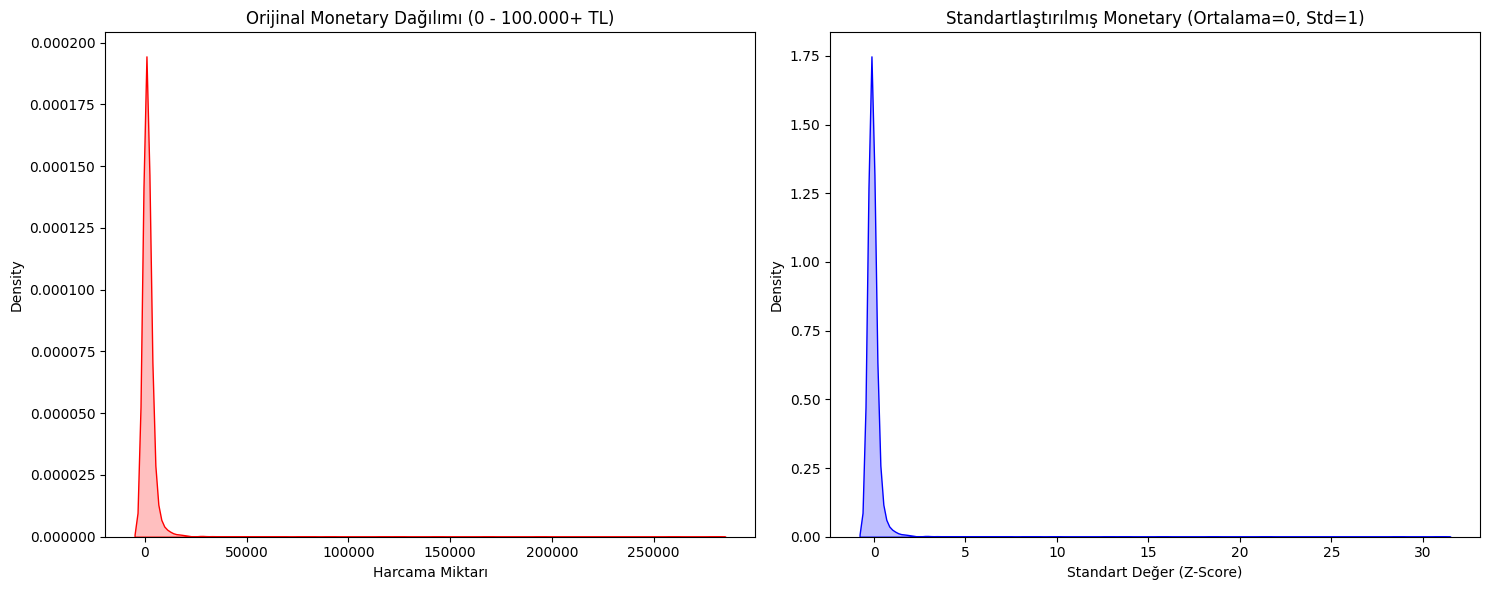

Görüldüğü üzere, orijinal verideki uçuk rakamlar (Binler, Milyonlar),
standartlaştırma sonrası -2 ile +2 arasına indirgenmiştir.


In [5]:
from sklearn.preprocessing import StandardScaler

#veriyi ölçeklendirme (scaling)

scaler= StandardScaler() #scaler nesnesi yaratıyoruz

rfm_scaled= scaler.fit_transform(rfm) # veriyi 'fit' et (öğren) ve 'transform' et (dönüştür)

rfm_scaled_df= pd.DataFrame(rfm_scaled, index=rfm.index, columns= rfm.columns) #çıktır bir 'numpy array' olur, biz bunu okuması kolay olsun diye tekrar 'DataFrame' yapalım

print("---Ölçeklendirme Öncesi İlk 3 satır---")
print(rfm.head(3))

print("\n---ölçeklendirme sonrası ilk 3 satır (standartlandırılmış)---")
print(rfm_scaled_df.head(3))

#artık sayıları 1000'ler 50'ler değil  de -1, 0, 1.5 gibi küçük standart sayılar oldu

import seaborn as sns
import matplotlib.pyplot as plt

# Görselleştirme: Normalizasyonun Etkisi (Before & After)
fig, axes = plt.subplots(1, 2, figsize=(15, 6))

sns.kdeplot(rfm['Monetary'], ax=axes[0], color='red', fill=True)
axes[0].set_title('Orijinal Monetary Dağılımı (0 - 100.000+ TL)')
axes[0].set_xlabel('Harcama Miktarı')

sns.kdeplot(rfm_scaled_df['Monetary'], ax=axes[1], color='blue', fill=True)
axes[1].set_title('Standartlaştırılmış Monetary (Ortalama=0, Std=1)')
axes[1].set_xlabel('Standart Değer (Z-Score)')

plt.tight_layout()
plt.show()

print("Görüldüğü üzere, orijinal verideki uçuk rakamlar (Binler, Milyonlar),")
print("standartlaştırma sonrası -2 ile +2 arasına indirgenmiştir.")

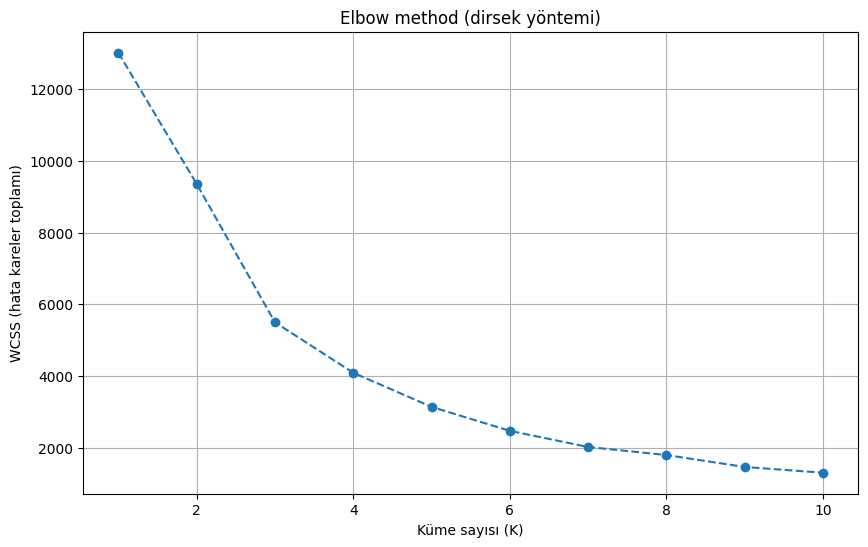

Silhouette Skoru (k=3): 0.5852924698124755


In [6]:
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt

#optimum küme sayısını bulma (elbow method)

wcss= [] #hata değerlerini (inertia) burada saklayacağız
for k in range (1,11):
    kmeans= KMeans (n_clusters=k, init='k-means++' , random_state=42)
    kmeans.fit(rfm_scaled_df)
    wcss.append(kmeans.inertia_) #inertia_ = WCSS değeridir
    
#grafiği çiz
plt.figure(figsize=(10,6))
plt.plot(range(1, 11), wcss, marker='o', linestyle= '--')
plt.title('Elbow method (dirsek yöntemi)')
plt.xlabel('Küme sayısı (K)')
plt.ylabel('WCSS (hata kareler toplamı)')
plt.grid(True)
plt.show()

from sklearn.metrics import silhouette_score

kmeans_final = KMeans(n_clusters=3, random_state=42).fit(rfm_scaled_df)
print(f"Silhouette Skoru (k=3): {silhouette_score(rfm_scaled_df, kmeans_final.labels_)}")


In [7]:
kmeans= KMeans(n_clusters=3, init='k-means++', random_state=42) #modeli k=3 ile kuruyoruz

cluster_labels= kmeans.fit_predict(rfm_scaled_df)  #fit_predict hem modeli eğitir hem de hangi müşterinin hangi kümeye girdiğini bulur

rfm['Cluster_ID'] = cluster_labels #küme etiketlerini (0,1,2) orijinal RFM tablosuna ekleyelim
#veriyi scale etmiştik ama sonuçları orijinal (okunabilir) tabloya yazıyoruz

print("Model başarıyla çalıştı ve müşteriler etiketlendi!")

#her kümede kaçar kişi var bakalım (dengeli mi dağılmış)
print("\n---küme başına müşteri sayıları---")
print(rfm['Cluster_ID'].value_counts())

print("\n---müşterilerin küme etiketleri---")
print(rfm.head())

Model başarıyla çalıştı ve müşteriler etiketlendi!

---küme başına müşteri sayıları---
Cluster_ID
0    3231
1    1093
2      14
Name: count, dtype: int64

---müşterilerin küme etiketleri---
             Recency  Frequency  Monetary  Cluster_ID
Customer ID                                          
12346.0          327          1  77183.60           1
12347.0            3          7   4310.00           0
12348.0           76          4   1797.24           0
12349.0           20          1   1757.55           0
12350.0          311          1    334.40           1


PCA analizi tamamlandı!


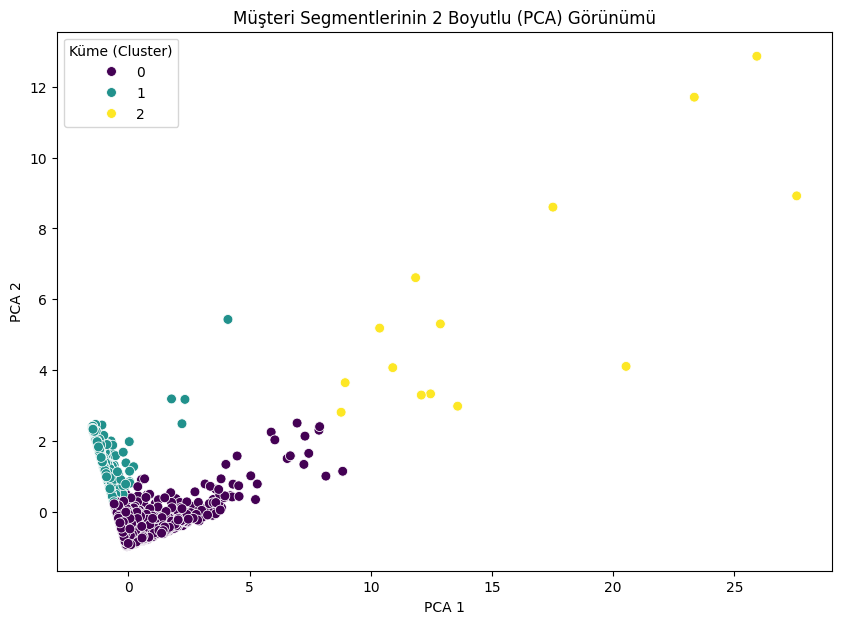

In [8]:
# --- PCA (Boyut İndirgeme) ---
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import seaborn as sns

# Veriyi 2 boyuta indiriyoruz (Görselleştirmek için)
pca = PCA(n_components=2)
pca_results = pca.fit_transform(rfm_scaled_df) 

# Sonuçları ana tabloya ekliyoruz
rfm['PCA1'] = pca_results[:, 0]
rfm['PCA2'] = pca_results[:, 1]

print("PCA analizi tamamlandı!")

# --- PCA Sonucunu Çizdirme ---
plt.figure(figsize=(10, 7))
sns.scatterplot(x='PCA1', y='PCA2', hue='Cluster_ID', data=rfm, palette='viridis', s=50)
plt.title('Müşteri Segmentlerinin 2 Boyutlu (PCA) Görünümü')
plt.xlabel('PCA 1')
plt.ylabel('PCA 2')
plt.legend(title='Küme (Cluster)')
plt.show()

In [10]:
# Şimdi ortalamaları alalım (Çift tırnak veya tek tırnak fark etmez, ikisi de çalışır)
analysis = rfm.groupby("Cluster_ID")[["Recency", "Frequency", "Monetary"]].mean()

print("--- KÜMELERİN ORTALAMALARI ---")
print(analysis)

--- KÜMELERİN ORTALAMALARI ---
               Recency  Frequency       Monetary
Cluster_ID                                      
0            41.983906   4.852677    2012.117191
1           247.023788   1.582800     631.141410
2             8.142857  80.214286  122888.407143


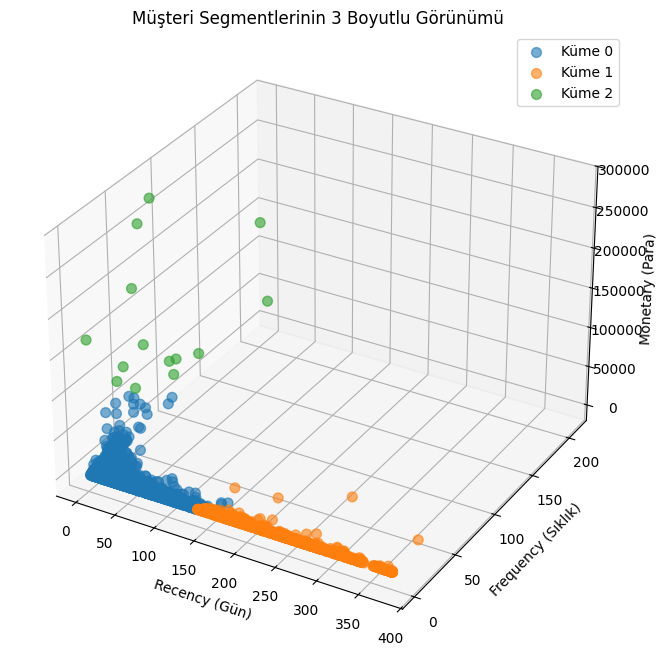

In [11]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

# 3D Grafik Oluşturma
fig = plt.figure(figsize=(12, 8))
ax = fig.add_subplot(111, projection='3d')

# Renkler (Cluster sayısı kadar renk)
colors = ['red', 'green', 'blue', 'purple']

# Her kümeyi döngüyle çizelim
for i in range(3): # Küme sayısı 3 olduğu için
    subset = rfm[rfm['Cluster_ID'] == i]
    ax.scatter(subset['Recency'], 
               subset['Frequency'], 
               subset['Monetary'], 
               s=50, # Nokta büyüklüğü
               label=f'Küme {i}',
               alpha=0.6) # Saydamlık

ax.set_xlabel('Recency (Gün)')
ax.set_ylabel('Frequency (Sıklık)')
ax.set_zlabel('Monetary (Para)')
ax.set_title('Müşteri Segmentlerinin 3 Boyutlu Görünümü')
plt.legend()
plt.show()